### Load Libraries

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

from scipy.cluster import hierarchy
from sklearn.decomposition import PCA

In [6]:
[i for i in os.listdir() if i.endswith('.data')]

['abalone.data']

### Load data

In [7]:
data = pd.read_csv('abalone.data', header=None)
data.columns = ["Sex", "Length", "Diam", "Height", "Whole", "Shucked", "Viscera", "Shell", "Rings"]
data.drop("Sex", axis=1, inplace=True)
data.head()

,Length,Diam,Height,Whole,Shucked,Viscera,Shell,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Length   4177 non-null   float64
 1   Diam     4177 non-null   float64
 2   Height   4177 non-null   float64
 3   Whole    4177 non-null   float64
 4   Shucked  4177 non-null   float64
 5   Viscera  4177 non-null   float64
 6   Shell    4177 non-null   float64
 7   Rings    4177 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 261.2 KB


In [9]:
data.describe().loc[["mean", "std", "min", "max"], :].style.background_gradient(axis=1)

,Length,Diam,Height,Whole,Shucked,Viscera,Shell,Rings
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


/home/codespace/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


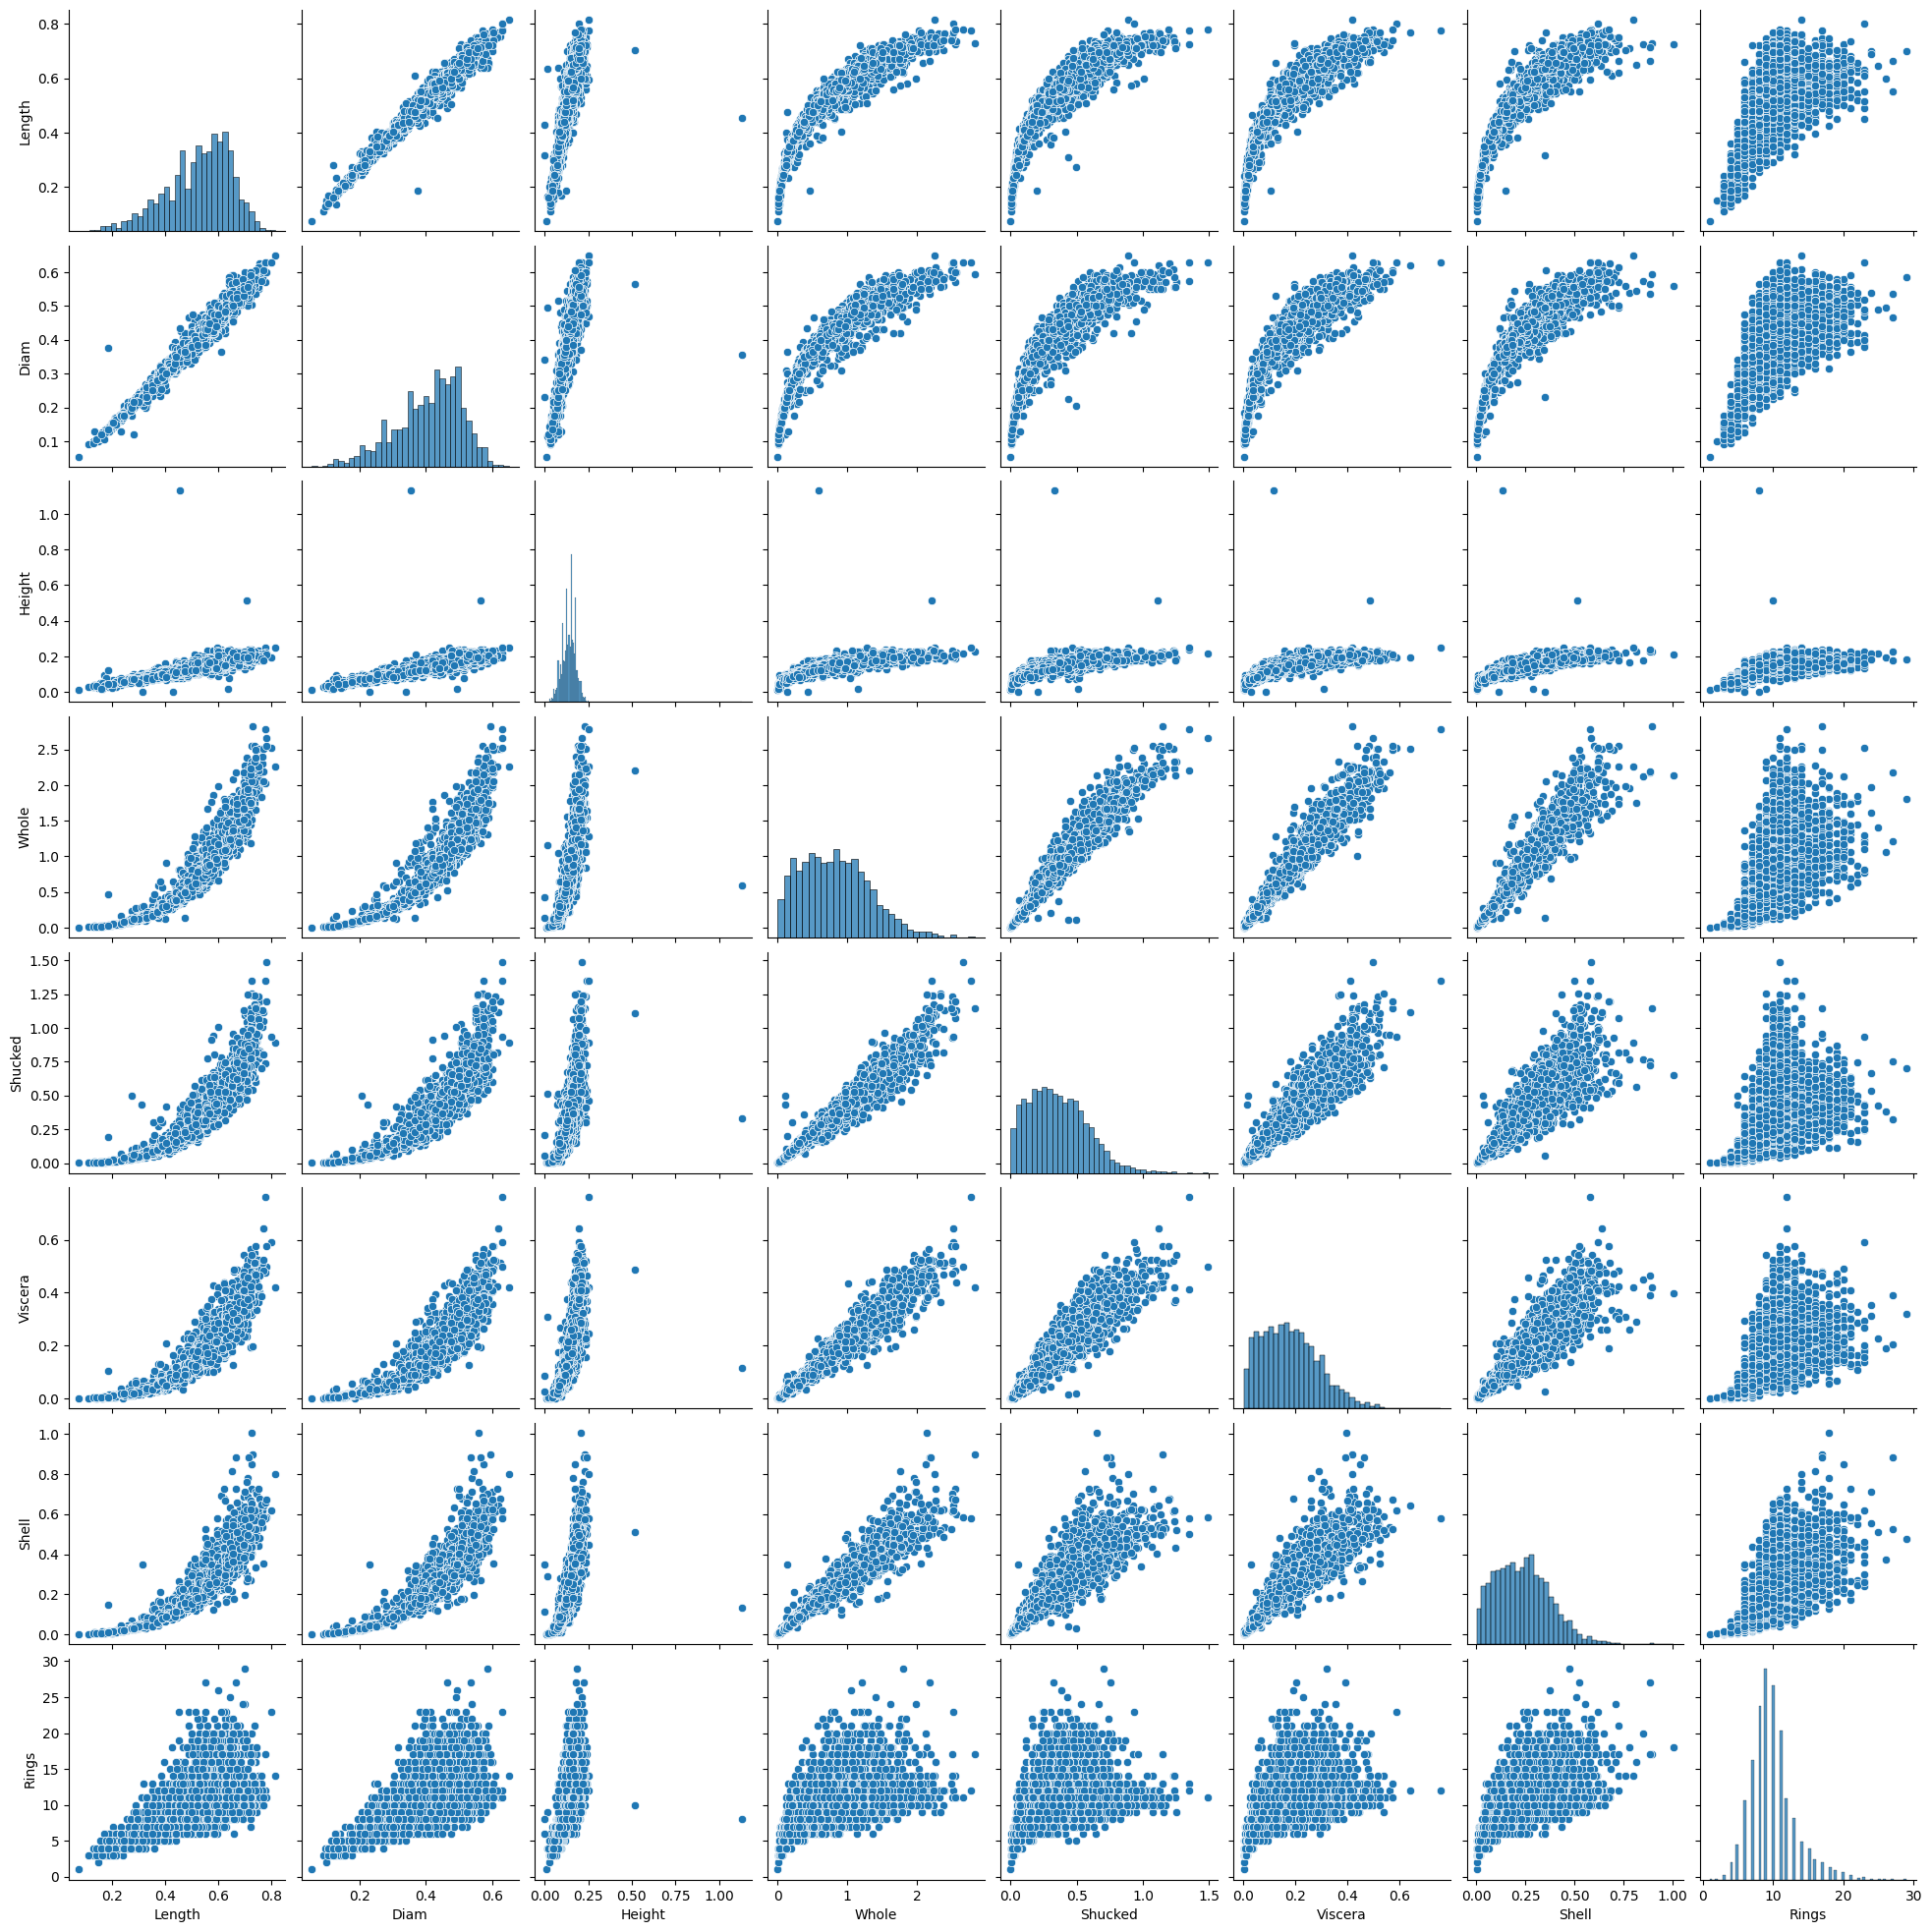

In [10]:
sns.pairplot(data);

### Data Preprocessing

De la gráfico de pares se puede ver que la variable de altura tiene valores atipicos, por lo que se procedera a removerlos

In [11]:
from scipy.stats import zscore

In [12]:
index_drop = (
    data
    .assign(
        z_score = lambda k: k[["Height"]].apply(zscore).abs()
    )
    .query("z_score > 3")
    .index
)

In [13]:
data = data.query("index not in @index_drop")

### Fit model with all variables

In [14]:
data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    random_state=42
)

In [15]:
# scaler = StandardScaler()
# scaler.set_output(transform='pandas')

In [16]:
X_train, y_train = data_train.drop("Rings", axis=1), data_train["Rings"]
X_test, y_test = data_test.drop("Rings", axis=1), data_test["Rings"]

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [18]:
predict = model.predict(X_test)

In [19]:
# calculate r_squared and rmse
r_squared = model.score(X_test, y_test)
rmse = np.sqrt(np.mean((predict - y_test) ** 2))

print(f"R-squared test: {r_squared}")
print(f"RMSE test: {rmse}")

R-squared test: 0.5684133045351263
RMSE test: 2.116680056877662


In [20]:
predict_train = model.predict(X_train)

In [21]:
# calculate r_squared and rmse for train
r_squared = model.score(X_train, y_train)
rmse = np.sqrt(np.mean((predict_train - y_train) ** 2))

print(f"R-squared train: {r_squared}")
print(f"RMSE train: {rmse}")

R-squared train: 0.524456318444894
RMSE train: 2.221146845231949


### Fit model after removing correlated features

#### Check Correlation

In [22]:
data.corr().style.background_gradient(cmap='coolwarm')

,Length,Diam,Height,Whole,Shucked,Viscera,Shell,Rings
Length,1.000000,0.986756,0.900583,0.925684,0.898469,0.903367,0.898655,0.555530
Diam,0.986756,1.000000,0.906923,0.925781,0.893588,0.899971,0.906263,0.573586
Height,0.900583,0.906923,1.000000,0.889000,0.837582,0.866889,0.892005,0.609258
Whole,0.925684,0.925781,0.889000,1.000000,0.969350,0.966267,0.955924,0.540181
Shucked,0.898469,0.893588,0.837582,0.969350,1.000000,0.931788,0.883118,0.420601
Viscera,0.903367,0.899971,0.866889,0.966267,0.931788,1.000000,0.908072,0.503512
Shell,0.898655,0.906263,0.892005,0.955924,0.883118,0.908072,1.000000,0.627833
Rings,0.555530,0.573586,0.609258,0.540181,0.420601,0.503512,0.627833,1.000000


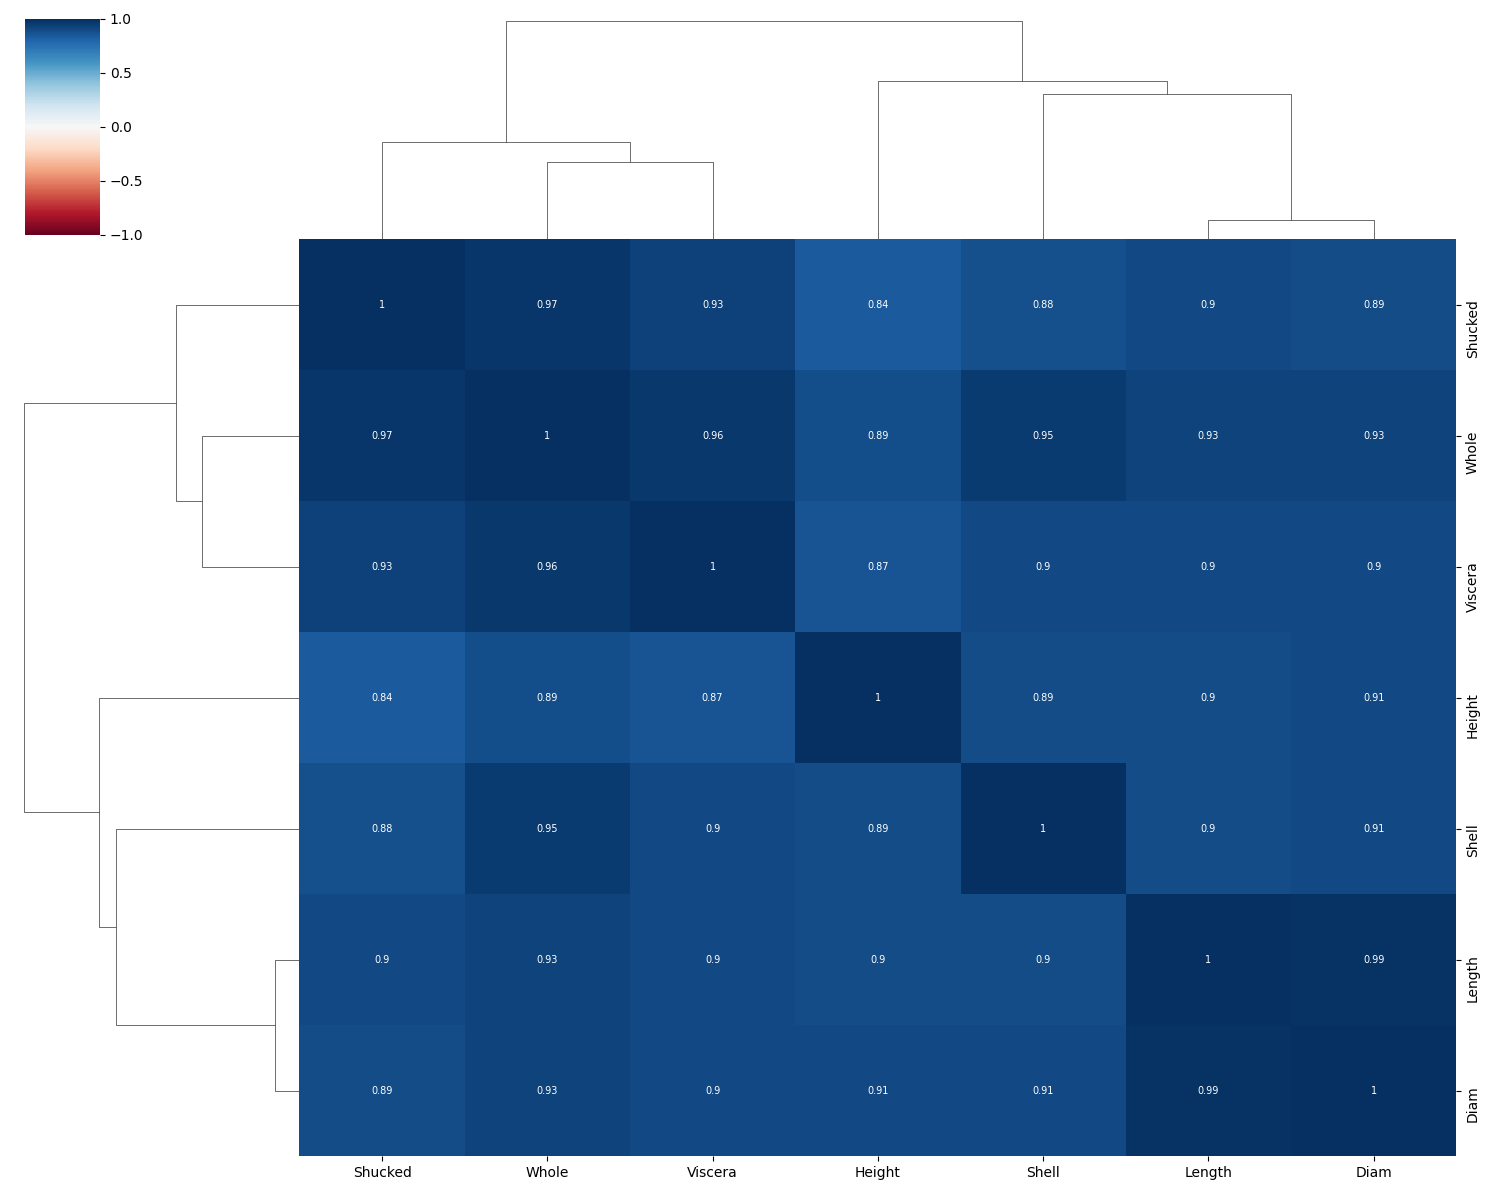

In [23]:
correlation = X_train.corr()
sns.clustermap(correlation, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));

Se puden obserar cuatro grupos de variables correlacionadas con un umbral de 0.5

#### Seleccionar variables

In [24]:
def selection_by_corr(dataset, threshold):
    corr_ = (dataset.corr() * -(np.identity(dataset.shape[1]) - 1)).abs()
    while corr_.max().max() > threshold:
        args = np.unravel_index(corr_.to_numpy().argmax(), corr_.shape)
        if corr_.iloc[args[0], :].mean() > corr_.iloc[:, args[1]].mean():
            name_drop = corr_.iloc[args[0], :].name
            corr_.drop(name_drop, axis=1, inplace=True)
            corr_.drop(name_drop, axis=0, inplace=True)
        else:
            name_drop = corr_.iloc[:, args[1]].name
            corr_.drop(name_drop, axis=1, inplace=True)
            corr_.drop(name_drop, axis=0, inplace=True)
    return corr_.columns.values

In [25]:
select_col = selection_by_corr(X_train, 0.9)
select_col

array(['Length', 'Height', 'Shucked', 'Shell'], dtype=object)

### Fit model with selected columns

In [26]:
X_train_select = X_train[select_col]
X_test_select = X_test[select_col]

In [27]:
model = LinearRegression()
model.fit(X_train_select, y_train)

LinearRegression()

In [28]:
predict = model.predict(X_test_select)

In [29]:
# calculate r_squared and rmse
r_squared = model.score(X_test_select, y_test)
rmse = np.sqrt(np.mean((predict - y_test) ** 2))

print(f"R-squared test: {r_squared}")
print(f"RMSE test: {rmse}")

R-squared test: 0.5418076989283924
RMSE test: 2.1809468787485153


In [30]:
predict_train = model.predict(X_train_select)

In [31]:
# calculate r_squared and rmse for train
r_squared = model.score(X_train_select, y_train)
rmse = np.sqrt(np.mean((predict_train - y_train) ** 2))

print(f"R-squared train: {r_squared}")
print(f"RMSE train: {rmse}")

R-squared train: 0.5059752315651025
RMSE train: 2.2638957570140232


### PCA

- Se crearan nuevas variables a partir de las variables originales, estas nuevas variables seran las variables originales.
- Se seleccionaran variables en base al grado de varianza.

#### Compute PCA

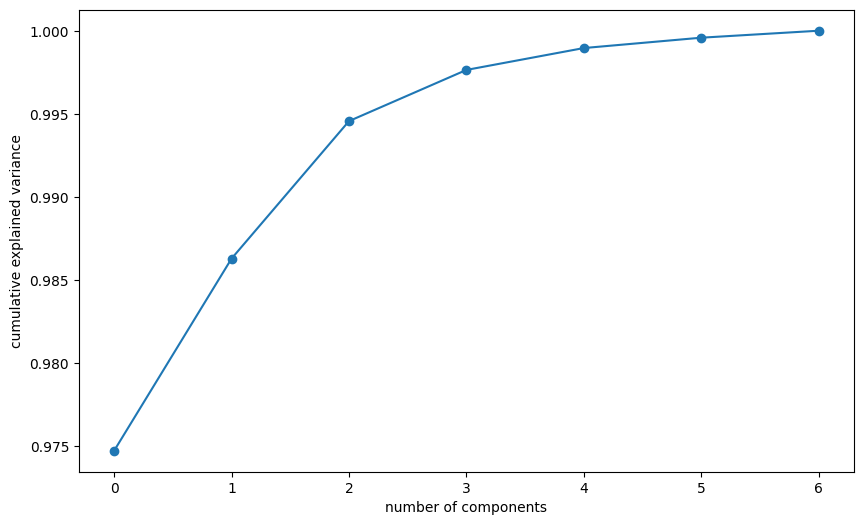

In [32]:
# plot the variance explained for each principal component
pca = PCA().fit(X_train)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# En base a la gráfica anterior, se seleccionan 3 componente principal

#### Seleccion de variables

In [33]:
pca = PCA(n_components=3)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#### Graficar

Text(0, 0.5, 'Rings')

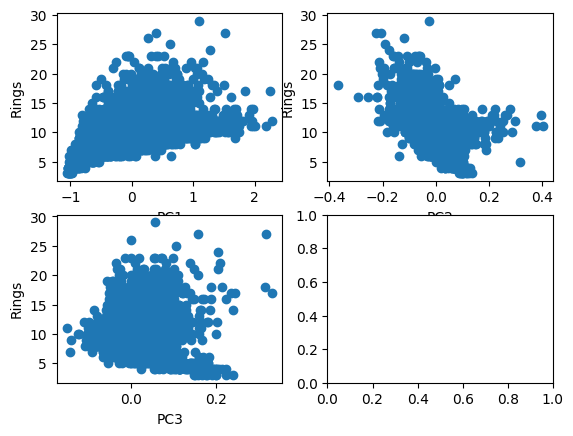

In [34]:
# Graficar las primeras 3 componentes principales
# contra la variable objetivo
fig = plt.subplots(2, 2)
plt.subplot(2, 2, 1)
plt.scatter(X_train_pca[:, 0], y_train)
plt.xlabel('PC1')
plt.ylabel('Rings')
plt.subplot(2, 2, 2)
plt.scatter(X_train_pca[:, 1], y_train)
plt.xlabel('PC2')
plt.ylabel('Rings')
plt.subplot(2, 2, 3)
plt.scatter(X_train_pca[:, 2], y_train)
plt.xlabel('PC3')
plt.ylabel('Rings')

#### Fit a model using the principal components

In [35]:
pca = PCA(n_components=3)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [36]:
model = LinearRegression()
model.fit(X_train_pca, y_train)

LinearRegression()

In [37]:
predict = model.predict(X_test_pca)

In [38]:
# calculate r_squared and rmse
r_squared = model.score(X_test_pca, y_test)
rmse = np.sqrt(np.mean((predict - y_test) ** 2))

print(f"R-squared test: {r_squared}")
print(f"RMSE test: {rmse}")

R-squared test: 0.551705771519148
RMSE test: 2.157261374995157


In [39]:
# calculate r_squared and rmse for train
predict_train = model.predict(X_train_pca)
r_squared = model.score(X_train_pca, y_train)
rmse = np.sqrt(np.mean((predict_train - y_train) ** 2))

print(f"R-squared train: {r_squared}")
print(f"RMSE train: {rmse}")

R-squared train: 0.5041976405072846
RMSE train: 2.267965054329409


### PLS

- Se crearan nuevas variables independientes y dependiente en base a la transformación de las variables originales.
- Se seleccionan las variables independiente hasta que las metricas decrementen.

In [40]:
pls = PLSRegression()
pls.fit(X_train, y_train)

predict = pls.predict(X_test)

# calculate r_squared and rmse
r_squared = pls.score(X_test, y_test)
rmse = np.sqrt(np.mean((predict.reshape(-1) - y_test) ** 2))

print(f"R-squared test: {r_squared}")
print(f"RMSE test: {rmse}")

R-squared test: 0.5171178673736936
RMSE test: 2.2389364251455612


#### Plot

In [41]:
pls = PLSRegression(n_components=4)
pls.fit(X_train, y_train)

X_train_pls = pls.transform(X_train)
X_test_pls = pls.transform(X_test)

Text(0, 0.5, 'Rings')

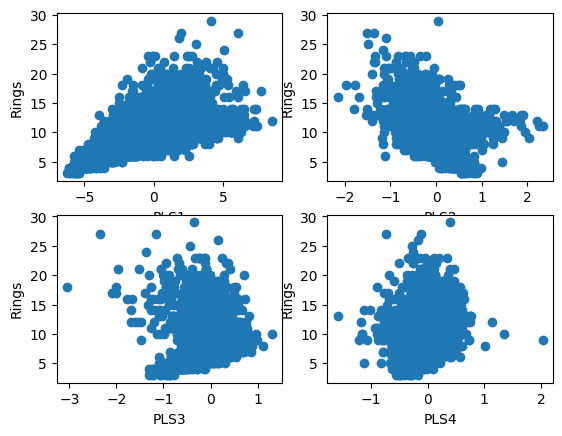

In [42]:
# Graficar las primeras 3 componentes principales
# contra la variable objetivo
fig = plt.subplots(2, 2)
plt.subplot(2, 2, 1)
plt.scatter(X_train_pls[:, 0], y_train)
plt.xlabel('PLS1')
plt.ylabel('Rings')
plt.subplot(2, 2, 2)
plt.scatter(X_train_pls[:, 1], y_train)
plt.xlabel('PLS2')
plt.ylabel('Rings')
plt.subplot(2, 2, 3)
plt.scatter(X_train_pls[:, 2], y_train)
plt.xlabel('PLS3')
plt.ylabel('Rings')
plt.subplot(2, 2, 4)
plt.scatter(X_train_pls[:, 3], y_train)
plt.xlabel('PLS4')
plt.ylabel('Rings')

In [43]:
# Remove variables iteratively
for i in range(X_train.shape[1], 0, -1):
    pls = PLSRegression(n_components=i)
    pls.fit(X_train, y_train)
    print(f"Number of components: {i}")
    # predict train
    predict_train = pls.predict(X_train)
    r_squared = pls.score(X_train, y_train)
    rmse = np.sqrt(np.mean((predict_train.reshape(-1) - y_train) ** 2))
    print(f"R-squared train: {r_squared:.4f}")
    print(f"RMSE train: {rmse:.4f}")
    # predict test
    predict = pls.predict(X_test)
    r_squared = pls.score(X_test, y_test)
    rmse = np.sqrt(np.mean((predict.reshape(-1) - y_test) ** 2))
    print(f"R-squared test: {r_squared:.4f}")
    print(f"RMSE test: {rmse:.4f}")

Number of components: 7
R-squared train: 0.5245
RMSE train: 2.2211
R-squared test: 0.5684
RMSE test: 2.1167
Number of components: 6
R-squared train: 0.5243
RMSE train: 2.2215
R-squared test: 0.5688
RMSE test: 2.1156
Number of components: 5
R-squared train: 0.5211
RMSE train: 2.2290
R-squared test: 0.5647
RMSE test: 2.1258
Number of components: 4
R-squared train: 0.5131
RMSE train: 2.2475
R-squared test: 0.5515
RMSE test: 2.1578
Number of components: 3
R-squared train: 0.5094
RMSE train: 2.2559
R-squared test: 0.5459
RMSE test: 2.1712
Number of components: 2
R-squared train: 0.4926
RMSE train: 2.2943
R-squared test: 0.5171
RMSE test: 2.2389
Number of components: 1
R-squared train: 0.3202
RMSE train: 2.6557
R-squared test: 0.3851
RMSE test: 2.5265


Existe un cambio significativo ahasta las 2 componentes, por lo que se utilizara un modelo con 3 componentes.

In [44]:
pls = PLSRegression(n_components=3)
pls.fit(X_train, y_train)

PLSRegression(n_components=3)

In [45]:
predict_train = pls.predict(X_train)
r_squared = pls.score(X_train, y_train)
rmse = np.sqrt(np.mean((predict_train.reshape(-1) - y_train) ** 2))
print(f"R-squared train: {r_squared:.4f}")
print(f"RMSE train: {rmse:.4f}")
# predict test
predict = pls.predict(X_test)
r_squared = pls.score(X_test, y_test)
rmse = np.sqrt(np.mean((predict.reshape(-1) - y_test) ** 2))
print(f"R-squared test: {r_squared:.4f}")
print(f"RMSE test: {rmse:.4f}")

R-squared train: 0.5094
RMSE train: 2.2559
R-squared test: 0.5459
RMSE test: 2.1712
